In [1]:
import os
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
from Bio import Entrez
from Bio import Medline
from gprofiler import GProfiler


In [2]:
df = pd.read_csv("../disprot/DisProt_release_2023_123_with_ambiguous_evidences.tsv", sep='\t')
uniprot_id_df = pd.read_csv("../uniprot_disorder_genes/idmapping_2024_09_19.tsv", sep='\t')
clinvar_missense_nopfam_df = pd.read_csv("../ClinVar/clinvar.snp.header.chr.nopfam.noalt.missense.cava.tsv", sep='\t')
ensemble_to_refseq_mapping_df = pd.read_csv("../gene2refseq/gene2ensembl.tsv", sep='\t')
wgs_bed_df = pd.read_csv("../gene2refseq/MANE_WGS.tsv", sep='\t')
af2_disorder_df = pd.read_csv("../alphafold/AlphaFold_disorder.human.tsv", sep='\t', header=None)
af2_disorder_df.columns = ['PID', 'START', "STOP", "GENE", 'ENSEMBLE_ID']
af2_disorder_df = af2_disorder_df[~af2_disorder_df['ENSEMBLE_ID'].isna()]                           
#mobidb_df = pd.read_csv('../mobidb/mobidb_result_2024-09-24T14_53_01.780Z.tsv', sep='\t')

/tmp/ipykernel_2265362/2709860477.py:3: DtypeWarning: Columns (52) have mixed types. Specify dtype option on import or set low_memory=False.
  clinvar_missense_nopfam_df = pd.read_csv("../ClinVar/clinvar.snp.header.chr.nopfam.noalt.missense.cava.tsv", sep='\t')


In [5]:
df_human = df[df['ncbi_taxon_id'] == 9606]
af2_disorder_df.GENE.value_counts()

ROCK1      14
MAGI1      11
EP300      11
ATG2A      11
TAF1       11
           ..
VPS36       1
HTRA2       1
BCAT1       1
DCLRE1C     1
TOB1        1
Name: GENE, Length: 834, dtype: int64

In [6]:
AF2_disorder_uniprod_df = pd.merge(af2_disorder_df, uniprot_id_df, left_on='PID' ,right_on='From', how='left')
AF2_disorder_uniprod_df#.Organism.value_counts()

PID  START  STOP      GENE        ENSEMBLE_ID    From   Entry  \
0     P50616    120   345      TOB1  ENST00000499247.3  P50616  P50616   
1     Q9UKX7      1   154     NUP50  ENST00000347635.9  Q9UKX7  Q9UKX7   
2     Q9UKX7    198   352     NUP50  ENST00000347635.9  Q9UKX7  Q9UKX7   
3     Q9NP98      1    44     MYOZ1  ENST00000359322.5  Q9NP98  Q9NP98   
4     Q9NP98     83   299     MYOZ1  ENST00000359322.5  Q9NP98  Q9NP98   
...      ...    ...   ...       ...                ...     ...     ...   
2141  P49918      1    45    CDKN1C  ENST00000440480.8  P49918  P49918   
2142  P49918     94   101    CDKN1C  ENST00000440480.8  P49918  P49918   
2143  P49918    105   316    CDKN1C  ENST00000440480.8  P49918  P49918   
2144  Q13542      1    24  EIF4EBP2  ENST00000373218.5  Q13542  Q13542   
2145  Q13542     67   120  EIF4EBP2  ENST00000373218.5  Q13542  Q13542   

      Reviewed   Entry Name  \
0     reviewed   TOB1_HUMAN   
1     reviewed  NUP50_HUMAN   
2     reviewed  NUP50_HUMAN   
3     reviewed  MYOZ1_HUMAN   
4     reviewed  MYOZ1_HUMAN   
...        ...          ...   
2141  reviewed  CDN1C_HUMAN   
2142  reviewed  CDN1C_HUMAN   
2143  reviewed  CDN1C_HUMAN   
2144  reviewed  4EBP2_HUMAN   
2145  reviewed  4EBP2_HUMAN   

                                          Protein names  \
0                 Protein Tob1 (Transducer of erbB-2 1)   
1     Nuclear pore complex protein Nup50 (50 kDa nuc...   
2     Nuclear pore complex protein Nup50 (50 kDa nuc...   
3     Myozenin-1 (Calsarcin-2) (Filamin-, actinin- a...   
4     Myozenin-1 (Calsarcin-2) (Filamin-, actinin- a...   
...                                                 ...   
2141  Cyclin-dependent kinase inhibitor 1C (Cyclin-d...   
2142  Cyclin-dependent kinase inhibitor 1C (Cyclin-d...   
2143  Cyclin-dependent kinase inhibitor 1C (Cyclin-d...   
2144  Eukaryotic translation initiation factor 4E-bi...   
2145  Eukaryotic translation initiation factor 4E-bi...   

                 Gene Names              Organism  Length AlphaFoldDB  GeneID  \
0            TOB1 TOB TROB1  Homo sapiens (Human)     345     P50616;  10140;   
1     NUP50 NPAP60L PRO1146  Homo sapiens (Human)     468     Q9UKX7;  10762;   
2     NUP50 NPAP60L PRO1146  Homo sapiens (Human)     468     Q9UKX7;  10762;   
3                MYOZ1 MYOZ  Homo sapiens (Human)     299     Q9NP98;  58529;   
4                MYOZ1 MYOZ  Homo sapiens (Human)     299     Q9NP98;  58529;   
...                     ...                   ...     ...         ...     ...   
2141            CDKN1C KIP2  Homo sapiens (Human)     316     P49918;   1028;   
2142            CDKN1C KIP2  Homo sapiens (Human)     316     P49918;   1028;   
2143            CDKN1C KIP2  Homo sapiens (Human)     316     P49918;   1028;   
2144               EIF4EBP2  Homo sapiens (Human)     120     Q13542;   1979;   
2145               EIF4EBP2  Homo sapiens (Human)     120     Q13542;   1979;   

       DisProt Gene Names (primary)                    MANE-Select  \
0     DP00794;                 TOB1             ENST00000499247.3;   
1     DP02455;                NUP50             ENST00000347635.9;   
2     DP02455;                NUP50             ENST00000347635.9;   
3          NaN                MYOZ1             ENST00000359322.5;   
4          NaN                MYOZ1             ENST00000359322.5;   
...        ...                  ...                            ...   
2141  DP00017;               CDKN1C  ENST00000440480.8 [P49918-2];   
2142  DP00017;               CDKN1C  ENST00000440480.8 [P49918-2];   
2143  DP00017;               CDKN1C  ENST00000440480.8 [P49918-2];   
2144  DP01293;             EIF4EBP2             ENST00000373218.5;   
2145  DP01293;             EIF4EBP2             ENST00000373218.5;   

                                                 RefSeq  
0            NP_001230806.1;NP_001230814.1;NP_005740.1;  
1     NP_009103.2 [Q9UKX7-1];NP_705931.1 [Q9UKX7-2];...  
2     NP_009103.2 [Q9UKX7-1];NP_705931.1 [Q9UKX7-2

In [7]:
def generate_gene_bed(df):
    filtered_df = df[~df['Gene Names (primary)'].str.contains(';', na=False)]
    new_df = filtered_df[[ 'START', 'STOP', 'Gene Names (primary)', 'RNA_nucleotide_accession.version', 'From']]
    new_df.columns = ['GSTART', "GEND", 'GENES', "TRANSCRIPT", "UNIPROT_ID"]
    new_df['TRANSCRIPT_NOV'] = new_df['TRANSCRIPT'].str.split('.').str[0]
    new_df = new_df.drop_duplicates()
    new_df = new_df.reset_index(drop=True)
    return new_df




In [8]:
#disorder_uniprod_df['ensemble_MANE'] = disorder_uniprod_df['MANE-Select'].str.split(";").str[0]
#disorder_uniprod_df['ensemble_MANE'] = disorder_uniprod_df['ensemble_MANE'].str.split(" ").str[0]


In [10]:
# Filter the DataFrame for rows where the value in 'RNA_nucleotide_accession.version' starts with 'NM_'
ensemble_to_refseq_df = ensemble_to_refseq_mapping_df[ensemble_to_refseq_mapping_df['RNA_nucleotide_accession.version'].str.startswith('NM_') &
                                                     ensemble_to_refseq_mapping_df['Ensembl_rna_identifier'].str.startswith('ENST')]
ensemble_to_refseq_df = ensemble_to_refseq_df[ensemble_to_refseq_df['#tax_id'] == 9606]
ensemble_to_refseq_df = ensemble_to_refseq_df[['RNA_nucleotide_accession.version', 'Ensembl_rna_identifier']]
ensemble_to_refseq_df = ensemble_to_refseq_df.drop_duplicates()
ensemble_to_refseq_df = ensemble_to_refseq_df.reset_index(drop=True)
ensemble_to_refseq_df

RNA_nucleotide_accession.version Ensembl_rna_identifier
0                          NM_130786.4      ENST00000263100.8
1                          NM_000014.6     ENST00000318602.12
2                          NM_000662.8      ENST00000307719.9
3                       NM_001160171.4      ENST00000518029.5
4                       NM_001160174.3      ENST00000520546.1
...                                ...                    ...
43304                   NM_001421901.1      ENST00000510875.1
43305                   NM_001422179.1      ENST00000444924.1
43306                   NM_001423836.2      ENST00000381497.6
43307                   NM_001394034.2      ENST00000715679.1
43308                   NM_001184780.2      ENST00000703585.1

[43309 rows x 2 columns]

In [11]:
disorder_uniprod_ref_df = pd.merge(AF2_disorder_uniprod_df, ensemble_to_refseq_df, left_on='ENSEMBLE_ID', 
                                   right_on='Ensembl_rna_identifier', how='left')
disorder_uniprod_ref_df.loc[
    (disorder_uniprod_ref_df['GENE'] == 'RYBP') & 
    (disorder_uniprod_ref_df['RNA_nucleotide_accession.version'].isna()), 
    'RNA_nucleotide_accession.version'
] = 'NM_012234.7'
disorder_uniprod_ref_df[disorder_uniprod_ref_df['GENE'] == 'RYBP']

PID  START  STOP  GENE        ENSEMBLE_ID    From   Entry  Reviewed  \
1741  Q8N488      1    26  RYBP  ENST00000643872.4  Q8N488  Q8N488  reviewed   
1742  Q8N488     47   160  RYBP  ENST00000643872.4  Q8N488  Q8N488  reviewed   
1743  Q8N488    164   228  RYBP  ENST00000643872.4  Q8N488  Q8N488  reviewed   

      Entry Name                                      Protein names  ...  \
1741  RYBP_HUMAN  RING1 and YY1-binding protein (Apoptin-associa...  ...   
1742  RYBP_HUMAN  RING1 and YY1-binding protein (Apoptin-associa...  ...   
1743  RYBP_HUMAN  RING1 and YY1-binding protein (Apoptin-associa...  ...   

                  Organism Length  AlphaFoldDB  GeneID   DisProt  \
1741  Homo sapiens (Human)    228      Q8N488;  23429;  DP00694;   
1742  Homo sapiens (Human)    228      Q8N488;  23429;  DP00694;   
1743  Homo sapiens (Human)    228      Q8N488;  23429;  DP00694;   

     Gene Names (primary)         MANE-Select        RefSeq  \
1741                 RYBP  ENST00000643872.4;  NP_036366.3;   
1742                 RYBP  ENST00000643872.4;  NP_036366.3;   
1743                 RYBP  ENST00000643872.4;  NP_036366.3;   

     RNA_nucleotide_accession.version Ensembl_rna_identifier  
1741                      NM_012234.7                    NaN  
1742                      NM_012234.7                    NaN  
1743                      NM_012234.7                    NaN  

[3 rows x 21 columns]

In [12]:
disorder_bed_df = generate_gene_bed(disorder_uniprod_ref_df)
disorder_bed_df
wgs_bed_df['TRANSCRIPT_NOV'] = wgs_bed_df['TRANSCRIPT'].str.split('.').str[0]


/tmp/ipykernel_2265362/929154101.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['TRANSCRIPT_NOV'] = new_df['TRANSCRIPT'].str.split('.').str[0]


In [13]:
disorder_bed_wgs_df = pd.merge(disorder_bed_df, wgs_bed_df, right_on='TRANSCRIPT_NOV', 
                               left_on='TRANSCRIPT_NOV', how='left')

disorder_genes= list(set(disorder_bed_wgs_df.GENES.tolist()))
disorder_disprot_df = disorder_bed_wgs_df[['CHROM', 'GSTART', 'GEND', 'GENES', 'TRANSCRIPT_x', 'TRANSCRIPT_NOV', 'UNIPROT_ID']]
                                           

In [14]:
print(len(disorder_genes))

834


In [15]:
disorder_disprot_df.to_csv("../AF2_disorder_regions.bed", sep='\t', index=False, header=None)


In [16]:
#clinvar_missense_nopfam_df = clinvar_missense_nopfam_df.replace('.', np.nan, inplace=True)
clinvar_data_df = clinvar_missense_nopfam_df[['#CHROM', "POS", "REF", "ALT", 
                                         'CAVA_CLASS', 'CAVA_CSN', 
                                         'CAVA_GENE', 'CAVA_GENEID', 'CAVA_IMPACT', 'CAVA_LOC', 'CAVA_PROTALT',
                                         'CAVA_PROTPOS', 'CAVA_PROTREF', 'CAVA_SO', 'CAVA_TRANSCRIPT', 
                                         'CLNSIG', 'CLNHGVS', 'CLNVC', 'CLNREVSTAT']]
clinvar_data_disorder_df =  clinvar_data_df[clinvar_data_df['CAVA_GENE'].isin(disorder_genes)]
clinvar_data_disorder_df = clinvar_data_disorder_df[clinvar_data_disorder_df['CAVA_SO'] == 'missense_variant']
clinvar_data_disorder_df.CLNSIG.value_counts()

keep_class = ['Likely_pathogenic', 'Pathogenic/Likely_pathogenic', 'Pathogenic|drug_response',
                    'Pathogenic', 'Pathogenic|other', 'Pathogenic/Likely_pathogenic|other', 'Likely_pathogenic|other',
                    'Likely_pathogenic/Likely_risk_allele', 'Likely_benign', 'Benign', 'Benign/Likely_benign', 'Uncertain_significance']
clinvar_data_disorder_keep_df = clinvar_data_disorder_df[clinvar_data_disorder_df['CLNSIG'].isin(keep_class)]



In [19]:
clinvar_data_disorder_merged_df = pd.merge(clinvar_data_disorder_keep_df, disorder_disprot_df, left_on='CAVA_GENE', right_on='GENES')
clinvar_data_disorder_merged_df['CAVA_PROTPOS'] = clinvar_data_disorder_merged_df['CAVA_PROTPOS'].astype(int)
clinvar_data_disorder_merged_df = clinvar_data_disorder_merged_df[clinvar_data_disorder_merged_df['CAVA_GENE'] != "PTEN"]
clinvar_data_disorder_merged_filtered_df = clinvar_data_disorder_merged_df[(clinvar_data_disorder_merged_df['CAVA_PROTPOS'] >= clinvar_data_disorder_merged_df['GSTART']) & (clinvar_data_disorder_merged_df['CAVA_PROTPOS'] <= clinvar_data_disorder_merged_df['GEND'])]
clnsig_counts = clinvar_data_disorder_merged_filtered_df.CLNSIG.value_counts()
clinvar_data_disorder_merged_filtered_df

#CHROM        POS REF ALT CAVA_CLASS              CAVA_CSN CAVA_GENE  \
0       chr1    3598933   G   T        NSY      c.4G>T_p.Ala2Ser      TP73   
4       chr1    3598961   G   T        NSY    c.32G>T_p.Gly11Val      TP73   
8       chr1    3599694   G   A        NSY   c.136G>A_p.Asp46Asn      TP73   
12      chr1    3599709   G   A        NSY   c.151G>A_p.Val51Ile      TP73   
16      chr1    3599731   C   G        NSY   c.173C>G_p.Thr58Ser      TP73   
...      ...        ...  ..  ..        ...                   ...       ...   
96244   chrX  153609522   C   T        NSY  c.730C>T_p.His244Tyr       EMD   
96245   chrX  153609538   A   G        NSY  c.746A>G_p.Glu249Gly       EMD   
96246   chrX  153609540   G   A        NSY  c.748G>A_p.Glu250Lys       EMD   
96247   chrX  153609554   C   G        NSY  c.762C>G_p.Phe254Leu       EMD   
96255   chrX  154563723   C   T        NSY     c.14G>A_p.Arg5Gln     CLIC2   

      CAVA_GENEID CAVA_IMPACT CAVA_LOC  ...                      CLNHGVS  \
0            7161           2      Ex2  ...    NC_000001.10:g.3598933G>T   
4            7161           2      Ex2  ...    NC_000001.10:g.3598961G>T   
8            7161           2      Ex3  ...    NC_000001.10:g.3599694G>A   
12           7161           2      Ex3  ...    NC_000001.10:g.3599709G>A   
16           7161           2      Ex3  ...    NC_000001.10:g.3599731C>G   
...           ...         ...      ...  ...                          ...   
96244        2010           2      Ex6  ...  NC_000023.10:g.153609522C>T   
96245        2010           2      Ex6  ...  NC_000023.10:g.153609538A>G   
96246        2010           2      Ex6  ...  NC_000023.10:g.153609540G>A   
96247        2010           2      Ex6  ...  NC_000023.10:g.153609554C>G   
96255        1193           2      Ex1  ...  NC_000023.10:g.154563723C>T   

                           CLNVC  \
0      single_nucleotide_variant   
4      single_nucleotide_variant   
8      single_nucleotide_variant   
12     single_nucleotide_variant   
16     single_nucleotide_variant   
...                          ...   
96244  single_nucleotide_variant   
96245  single_nucleotide_variant   
96246  single_nucleotide_variant   
96247  single_nucleotide_variant   
96255  single_nucleotide_variant   

                                              CLNREVSTAT CHROM GSTART GEND  \
0                    criteria_provided,_single_submitter  chr1      1  114   
4                    criteria_provided,_single_submitter  chr1      1  114   
8                    criteria_provided,_single_submitter  chr1      1  114   
12                   criteria_provided,_single_submitter  chr1      1  114   
16                   criteria_provided,_single_submitter  chr1      1  114   
...                                                  ...   ...    ...  ...   
96244                     no_assertion_criteria_provided  chrX     47  254   
96245  criteria_provided,_multiple_submitters,_no_con...  chrX     47  254   
96246                criteria_provided,_single_submitter  chrX     47  254   
96247                criteria_provided,_single_submitter  chrX     47  254   
96255                criteria_provided,_single_submitter  chrX      1    9   

       GENES TRANSCRIPT_x TRANSCRIPT_NOV UNIPROT_ID  
0       TP73  NM_005427.4      NM_005427     O15350  
4       TP73  NM_005427.4      NM_005427     O15350  
8       TP73  NM_005427.4      NM_005427     O15350  
12      TP73  NM_005427.4      NM_005427     O15350  
16      TP73  NM_005427.4      NM_005427     O15350  
...      ...          ...            ...        ...  
96244    EMD  NM_000117.3      NM_000117     P50402  
96245    EMD  NM_000117.3      NM_000117     P50402  
96246    EMD  NM_000117.3      NM_000117     P50402  
96247    EMD  NM_000117.3      NM_000117     P50402  
96255  CLIC2  NM_001289.6      NM_001289     O15247  

[15999 rows x 26 columns]

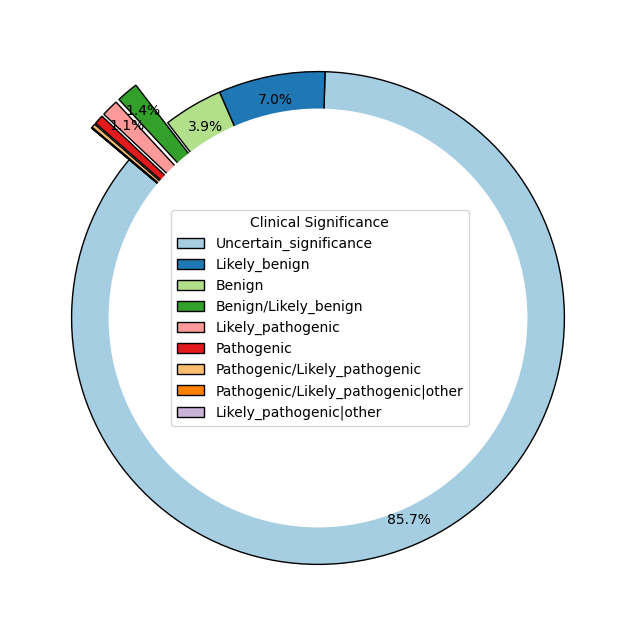

In [21]:
# Set up the figure size
plt.figure(figsize=(8, 8))

# Create a donut chart with optimized label placement
wedges, texts, autotexts = plt.pie(
    clnsig_counts.values, 
    labels=None,  # Hide labels in the pie to prevent overlap
    autopct=lambda p: f'{p:.1f}%' if p > 1 else '',  # Hide very small percentages
    startangle=140,  # Rotate for better visualization
    colors=plt.cm.Paired.colors,  # Use a diverse colormap
    wedgeprops={'edgecolor': 'black'},  # Add border to slices
    pctdistance=0.90,  # Push percentage labels closer to slices
    explode=[0.2 if val < 500 else 0 for val in clnsig_counts.values]  # Separate small slices
)

# Draw a white circle in the middle to make it a donut chart
centre_circle = plt.Circle((0, 0), 0.85, fc='white')
plt.gca().add_artist(centre_circle)

# Add category labels outside the pie chart
plt.legend(wedges, clnsig_counts.index, title="Clinical Significance", loc="center left", bbox_to_anchor=(0.25, 0.5))
plt.savefig("clinvar_idr_distribution.png", dpi=300)
# Set title
#plt.title("Distribution of Clinical Significance Labels", fontsize=14)

# Show the plot
plt.show()

In [22]:
pathogenic_class = ['Likely_pathogenic', 'Pathogenic', 'Pathogenic/Likely_pathogenic', 
                    'Pathogenic/Likely_pathogenic|other', 'Likely_pathogenic|other']
clinvar_data_disorder_pathogenic_df = clinvar_data_disorder_merged_filtered_df[clinvar_data_disorder_merged_filtered_df['CLNSIG'].isin(pathogenic_class)] 
clinvar_data_disorder_pathogenic_df = clinvar_data_disorder_pathogenic_df.drop(['CHROM', 'GSTART', 'GEND', 'TRANSCRIPT_x'], axis=1)
clinvar_data_disorder_pathogenic_df = clinvar_data_disorder_pathogenic_df[clinvar_data_disorder_pathogenic_df['CAVA_GENE'] != "PTEN"]
clinvar_data_disorder_pathogenic_df = clinvar_data_disorder_pathogenic_df.drop_duplicates()
clinvar_data_disorder_pathogenic_df = clinvar_data_disorder_pathogenic_df.reset_index(drop=True)
disorder_pathogenic_genes = list(set(clinvar_data_disorder_pathogenic_df.CAVA_GENE.tolist()))
clinvar_data_disorder_pathogenic_df['Class'] = 'Deleterious'
clinvar_data_disorder_pathogenic_df['Class'].value_counts()

Deleterious    322
Name: Class, dtype: int64

In [23]:
benign_class = ['Likely_benign', 'Benign', 'Benign/Likely_benign']
clinvar_data_disorder_benign_df = clinvar_data_disorder_merged_filtered_df[clinvar_data_disorder_merged_filtered_df['CLNSIG'].isin(benign_class)] 
clinvar_data_disorder_benign_df = clinvar_data_disorder_benign_df.drop(['CHROM', 'GSTART', 'GEND', 'TRANSCRIPT_x'], axis=1)
clinvar_data_disorder_benign_df = clinvar_data_disorder_benign_df[clinvar_data_disorder_benign_df['CAVA_GENE'] != "PTEN"]
clinvar_data_disorder_benign_df = clinvar_data_disorder_benign_df.drop_duplicates()
clinvar_data_disorder_benign_df = clinvar_data_disorder_benign_df.reset_index(drop=True)
#clinvar_data_disorder_benign_df = clinvar_data_disorder_benign_df[clinvar_data_disorder_benign_df['CAVA_GENE'].isin(disorder_pathogenic_genes)]
clinvar_data_disorder_benign_df = clinvar_data_disorder_benign_df.drop_duplicates()
clinvar_data_disorder_benign_df = clinvar_data_disorder_benign_df.reset_index(drop=True)
clinvar_data_disorder_benign_df['Class'] = 'Neutral'
clinvar_data_disorder_benign_df.Class.value_counts()

Neutral    1973
Name: Class, dtype: int64

In [24]:
vus_class = ['Uncertain_significance']
clinvar_data_disorder_vus_df = clinvar_data_disorder_merged_filtered_df[clinvar_data_disorder_merged_filtered_df['CLNSIG'].isin(vus_class)] 
clinvar_data_disorder_vus_df = clinvar_data_disorder_vus_df.drop(['CHROM', 'GSTART', 'GEND', 'TRANSCRIPT_x'], axis=1)
clinvar_data_disorder_vus_df = clinvar_data_disorder_vus_df[clinvar_data_disorder_vus_df['CAVA_GENE'] != "PTEN"]
clinvar_data_disorder_vus_df = clinvar_data_disorder_vus_df.drop_duplicates()
clinvar_data_disorder_vus_df = clinvar_data_disorder_vus_df.reset_index(drop=True)
disorder_vus_genes = list(set(clinvar_data_disorder_vus_df.CAVA_GENE.tolist()))
clinvar_data_disorder_vus_df['Class'] = 'VUS'
clinvar_data_disorder_vus_df['Class'].value_counts()

VUS    13704
Name: Class, dtype: int64

In [25]:
clinvar_data_disorder_results_df = pd.concat([clinvar_data_disorder_pathogenic_df, clinvar_data_disorder_benign_df, clinvar_data_disorder_vus_df], axis=0)

/tmp/ipykernel_2265362/4205326587.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=clnsig_updated_counts.index, y=clnsig_updated_counts.values, palette="viridis")


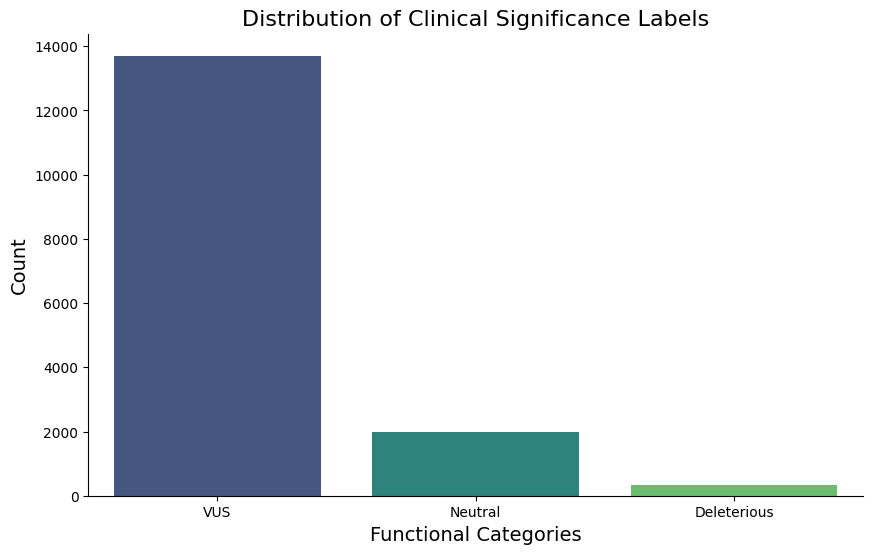

In [37]:
clnsig_updated_counts = clinvar_data_disorder_results_df.Class.value_counts()

# Set up the figure size
plt.figure(figsize=(10, 6))

# Create a bar plot
sns.barplot(x=clnsig_updated_counts.index, y=clnsig_updated_counts.values, palette="viridis")

# Labels and title
plt.xlabel("Functional Categories", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.title("Distribution of Clinical Significance Labels", fontsize=16)
sns.despine()
# Rotate x-axis labels for better readability
#plt.xticks(rotation=45, ha='right')
plt.savefig("disorder_idr_mutation_counts.png", dpi=300)
# Show the plot
plt.show()

In [27]:
clinvar_AF2_disorder_results_df = clinvar_data_disorder_results_df[[ 'CAVA_CSN','CAVA_PROTALT',
       'CAVA_PROTPOS', 'CAVA_PROTREF', 'CAVA_TRANSCRIPT', 'CLNSIG',
       'CLNHGVS', 'GENES',
       'UNIPROT_ID', 'Class']]
clinvar_AF2_disorder_results_df['mutation'] = (
    clinvar_AF2_disorder_results_df['CAVA_PROTREF'].astype(str) +
    clinvar_AF2_disorder_results_df['CAVA_PROTPOS'].astype(str) +
    clinvar_AF2_disorder_results_df['CAVA_PROTALT'].astype(str)
)
clinvar_AF2_disorder_results_df

/tmp/ipykernel_2265362/2673966800.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clinvar_AF2_disorder_results_df['mutation'] = (


CAVA_CSN CAVA_PROTALT  CAVA_PROTPOS CAVA_PROTREF  \
0      c.1262C>T_p.Pro421Leu            L           421            P   
1        c.140T>C_p.Leu47Pro            P            47            L   
2         c.94G>A_p.Glu32Lys            K            32            E   
3        c.140C>G_p.Ser47Cys            C            47            S   
4          c.11C>A_p.Pro4Gln            Q             4            P   
...                      ...          ...           ...          ...   
13699   c.725T>G_p.Ile242Ser            S           242            I   
13700   c.728A>C_p.Tyr243Ser            S           243            Y   
13701   c.730C>T_p.His244Tyr            Y           244            H   
13702   c.762C>G_p.Phe254Leu            L           254            F   
13703      c.14G>A_p.Arg5Gln            Q             5            R   

      CAVA_TRANSCRIPT                        CLNSIG  \
0         NM_006559.3             Likely_pathogenic   
1         NM_004700.4  Pathogenic/Likely_pathogenic   
2         NM_174936.4  Pathogenic/Likely_pathogenic   
3         NM_174936.4                    Pathogenic   
4         NM_170707.4             Likely_pathogenic   
...               ...                           ...   
13699     NM_000117.3        Uncertain_significance   
13700     NM_000117.3        Uncertain_significance   
13701     NM_000117.3        Uncertain_significance   
13702     NM_000117.3        Uncertain_significance   
13703     NM_001289.6        Uncertain_significance   

                           CLNHGVS    GENES UNIPROT_ID        Class mutation  
0       NC_000001.10:g.32508155C>T  KHDRBS1     Q07666  Deleterious    P421L  
1       NC_000001.10:g.41249905T>C    KCNQ4     P56696  Deleterious     L47P  
2       NC_000001.10:g.55505604G>A    PCSK9     Q8NBP7  Deleterious     E32K  
3       NC_000001.10:g.55505650C>G    PCSK9     Q8NBP7  Deleterious     S47C  
4      NC_000001.10:g.156084720C>A     LMNA     P02545  Deleterious      P4Q  
...                            ...      ...        ...          ...      ...  
13699  NC_000023.10:g.153609517T>G      EMD     P50402          VUS    I242S  
13700  NC_000023.10:g.153609520A>C      EMD     P50402          VUS    Y243S  
13701  NC_000023.10:g.153609522C>T      EMD     P50402          VUS    H244Y  
13702  NC_000023.10:g.153609554C>G      EMD     P50402          VUS    F254L  
13703  NC_000023.10:g.154563723C>T    CLIC2     O15247          VUS      R5Q  

[15999 rows x 11 columns]

In [28]:
clinvar_AF2_disorder_results_merge_df = pd.merge(clinvar_AF2_disorder_results_df, disorder_disprot_df, on="GENES", how="inner")

clinvar_AF2_disorder_results_merge_df["within_interval"] = (clinvar_AF2_disorder_results_merge_df["CAVA_PROTPOS"] >= clinvar_AF2_disorder_results_merge_df["GSTART"]) & (clinvar_AF2_disorder_results_merge_df["CAVA_PROTPOS"] <= clinvar_AF2_disorder_results_merge_df["GEND"])
clinvar_AF2_disorder_results_merge_df = clinvar_AF2_disorder_results_merge_df[clinvar_AF2_disorder_results_merge_df["within_interval"]]
clinvar_AF2_disorder_results_merge_df

CAVA_CSN CAVA_PROTALT  CAVA_PROTPOS CAVA_PROTREF  \
2      c.1262C>T_p.Pro421Leu            L           421            P   
3         c.38G>C_p.Arg13Pro            P            13            R   
6         c.44C>T_p.Ser15Leu            L            15            S   
9         c.58T>C_p.Ser20Pro            P            20            S   
12       c.113C>T_p.Pro38Leu            L            38            P   
...                      ...          ...           ...          ...   
59337   c.313G>C_p.Ala105Pro            P           105            A   
59339   c.347G>A_p.Gly116Glu            E           116            G   
59340     c.55A>G_p.Met19Val            V            19            M   
59341     c.28A>G_p.Met10Val            V            10            M   
59342      c.14G>A_p.Arg5Gln            Q             5            R   

      CAVA_TRANSCRIPT                  CLNSIG                      CLNHGVS  \
2         NM_006559.3       Likely_pathogenic   NC_000001.10:g.32508155C>T   
3         NM_006559.3  Uncertain_significance   NC_000001.10:g.32479634G>C   
6         NM_006559.3  Uncertain_significance   NC_000001.10:g.32479640C>T   
9         NM_006559.3  Uncertain_significance   NC_000001.10:g.32479654T>C   
12        NM_006559.3  Uncertain_significance   NC_000001.10:g.32479709C>T   
...               ...                     ...                          ...   
59337     NM_005032.7  Uncertain_significance  NC_000023.10:g.114863585G>C   
59339     NM_005032.7  Uncertain_significance  NC_000023.10:g.114863619G>A   
59340     NM_004344.3  Uncertain_significance  NC_000023.10:g.151998253T>C   
59341     NM_004344.3  Uncertain_significance  NC_000023.10:g.151998280T>C   
59342     NM_001289.6  Uncertain_significance  NC_000023.10:g.154563723C>T   

         GENES UNIPROT_ID_x        Class mutation CHROM  GSTART  GEND  \
2      KHDRBS1       Q07666  Deleterious    P421L  chr1     275   443   
3      KHDRBS1       Q07666          VUS     R13P  chr1       1   106   
6      KHDRBS1       Q07666          VUS     S15L  chr1       1   106   
9      KHDRBS1       Q07666          VUS     S20P  chr1       1   106   
12     KHDRBS1       Q07666          VUS     P38L  chr1       1   106   
...        ...          ...          ...      ...   ...     ...   ...   
59337     PLS3       P13797          VUS    A105P  chrX     103   117   
59339     PLS3       P13797          VUS    G116E  chrX     103   117   
59340    CETN2       P41208          VUS     M19V  chrX       1    27   
59341    CETN2       P41208          VUS     M10V  chrX       1    27   
59342    CLIC2       O15247          VUS      R5Q  chrX       1     9   

      TRANSCRIPT_x TRANSCRIPT_NOV UNIPROT_ID_y  within_interval  
2      NM_006559.3      NM_006559       Q07666             True  
3      NM_006559.3      NM_006559       Q07666             True  
6      NM_006559.3      NM_006559       Q07666             True  
9      NM_006559.3      NM_006559       Q07666             True  
12     NM_006559.3      NM_006559       Q07666             True  
...            ...            ...          ...              ...  
59337  NM_005032.7      NM_005032       P13797             True  
59339  NM_005032.7      NM_005032       P13797             True  
59340  NM_004344.3      NM_004344       P41208             True  
59341  NM_004344.3      NM_004344       P41208             True  
59342  NM_001289.6      NM_001289       O15247             True  

[15999 rows x 18 columns]

In [29]:
clinvar_AF2_disorder_results_merge_df.to_csv('../alphafold/AF2_Disorder_deleterious_neutral_vus_results.tsv', sep='\t', index=False)

clinvar_AF2_disorder_results_merge_df[clinvar_AF2_disorder_results_merge_df.CHROM.isna()]

Empty DataFrame
Columns: [CAVA_CSN, CAVA_PROTALT, CAVA_PROTPOS, CAVA_PROTREF, CAVA_TRANSCRIPT, CLNSIG, CLNHGVS, GENES, UNIPROT_ID_x, Class, mutation, CHROM, GSTART, GEND, TRANSCRIPT_x, TRANSCRIPT_NOV, UNIPROT_ID_y, within_interval]
Index: []

In [30]:
study_gene_list = list(set(clinvar_data_disorder_results_df.CAVA_GENE.tolist()))
study_gene_list = study_gene_list + ['BRCA2', "PALB2", "RAD51C", "PALB2", "TP53"]

In [31]:
with open ("../aim2_gene_list.csv", 'w+') as fout:
    for i in study_gene_list:
        fout.write(i + '\n')

In [32]:
study_regions_df = wgs_bed_df[wgs_bed_df['GENE'].isin(study_gene_list)]
study_regions_df = study_regions_df.drop_duplicates()
study_regions_df = study_regions_df.reset_index(drop=True)
study_regions_df.to_csv("../aim2_regions_genes.tsv", sep='\t', index=False)

In [33]:
clinvar_data_disorder_results_df#[['CAVA_GENE']].value_counts()

#CHROM        POS REF ALT CAVA_CLASS               CAVA_CSN CAVA_GENE  \
0       chr1   32508155   C   T        NSY  c.1262C>T_p.Pro421Leu   KHDRBS1   
1       chr1   41249905   T   C        NSY    c.140T>C_p.Leu47Pro     KCNQ4   
2       chr1   55505604   G   A        NSY     c.94G>A_p.Glu32Lys     PCSK9   
3       chr1   55505650   C   G        NSY    c.140C>G_p.Ser47Cys     PCSK9   
4       chr1  156084720   C   A        NSY      c.11C>A_p.Pro4Gln      LMNA   
...      ...        ...  ..  ..        ...                    ...       ...   
13699   chrX  153609517   T   G        NSY   c.725T>G_p.Ile242Ser       EMD   
13700   chrX  153609520   A   C        NSY   c.728A>C_p.Tyr243Ser       EMD   
13701   chrX  153609522   C   T        NSY   c.730C>T_p.His244Tyr       EMD   
13702   chrX  153609554   C   G        NSY   c.762C>G_p.Phe254Leu       EMD   
13703   chrX  154563723   C   T        NSY      c.14G>A_p.Arg5Gln     CLIC2   

      CAVA_GENEID CAVA_IMPACT CAVA_LOC  ...           CAVA_SO  \
0           10657           2      Ex9  ...  missense_variant   
1            9132           2      Ex1  ...  missense_variant   
2          255738           2      Ex1  ...  missense_variant   
3          255738           2      Ex1  ...  missense_variant   
4            4000           2      Ex1  ...  missense_variant   
...           ...         ...      ...  ...               ...   
13699        2010           2      Ex6  ...  missense_variant   
13700        2010           2      Ex6  ...  missense_variant   
13701        2010           2      Ex6  ...  missense_variant   
13702        2010           2      Ex6  ...  missense_variant   
13703        1193           2      Ex1  ...  missense_variant   

       CAVA_TRANSCRIPT                        CLNSIG  \
0          NM_006559.3             Likely_pathogenic   
1          NM_004700.4  Pathogenic/Likely_pathogenic   
2          NM_174936.4  Pathogenic/Likely_pathogenic   
3          NM_174936.4                    Pathogenic   
4          NM_170707.4             Likely_pathogenic   
...                ...                           ...   
13699      NM_000117.3        Uncertain_significance   
13700      NM_000117.3        Uncertain_significance   
13701      NM_000117.3        Uncertain_significance   
13702      NM_000117.3        Uncertain_significance   
13703      NM_001289.6        Uncertain_significance   

                           CLNHGVS                      CLNVC  \
0       NC_000001.10:g.32508155C>T  single_nucleotide_variant   
1       NC_000001.10:g.41249905T>C  single_nucleotide_variant   
2       NC_000001.10:g.55505604G>A  single_nucleotide_variant   
3       NC_000001.10:g.55505650C>G  single_nucleotide_variant   
4      NC_000001.10:g.156084720C>A  single_nucleotide_variant   
...                            ...                        ...   
13699  NC_000023.10:g.153609517T>G  single_nucleotide_variant   
13700  NC_000023.10:g.153609520A>C  single_nucleotide_variant   
13701  NC_000023.10:g.153609522C>T  single_nucleotide_variant   
13702  NC_000023.10:g.153609554C>G  single_nucleotide_variant   
13703  NC_000023.10:g.154563723C>T  single_nucleotide_variant   

                                              CLNREVSTAT    GENES  \
0                    criteria_provided,_single_submitter  KHDRBS1   
1      criteria_provided,_multiple_submitters,_no_con...    KCNQ4   
2      criteria_provided,_multiple_submitters,_no_con...    PCSK9   
3                         no_assertion_criteria_provided    PCSK9   
4                    criteria_provided,_single_submitter     LMNA   
...                                                  ...      ...   
13699                criteria_provided,_single_submitter      EMD   
13700                criteria_provided,_single_submitter      EMD   
13701                     no_assertion_criteria_provided      EMD   
13702                criteria_provided,_single_submitter      EMD   
13703                criteria_provided,_single_submitter    CLI

In [34]:
clinvar_data_disorder_results_df.columns

Index(['#CHROM', 'POS', 'REF', 'ALT', 'CAVA_CLASS', 'CAVA_CSN', 'CAVA_GENE',
       'CAVA_GENEID', 'CAVA_IMPACT', 'CAVA_LOC', 'CAVA_PROTALT',
       'CAVA_PROTPOS', 'CAVA_PROTREF', 'CAVA_SO', 'CAVA_TRANSCRIPT', 'CLNSIG',
       'CLNHGVS', 'CLNVC', 'CLNREVSTAT', 'GENES', 'TRANSCRIPT_NOV',
       'UNIPROT_ID', 'Class'],
      dtype='object')

In [35]:
from gprofiler import GProfiler
def get_go_terms(gene_name):
    gp = GProfiler(return_dataframe=True)
    result = gp.profile(organism='hsapiens', query=gene_name)
    go_terms = result[['native', 'name', 'source', 'p_value']]
    #go_terms = go_terms[go_terms['native'].str.startswith("GO")]
    return go_terms

# Example Usage
gene = "TAF1"  # Example gene
go_terms_df = get_go_terms(gene)
print(go_terms_df)

       native                          name source   p_value
0  HP:0008468  Abnormal sacral segmentation     HP  0.049962


In [36]:
clinvar_AF2_disorder_results_merge_df

CAVA_CSN CAVA_PROTALT  CAVA_PROTPOS CAVA_PROTREF  \
2      c.1262C>T_p.Pro421Leu            L           421            P   
3         c.38G>C_p.Arg13Pro            P            13            R   
6         c.44C>T_p.Ser15Leu            L            15            S   
9         c.58T>C_p.Ser20Pro            P            20            S   
12       c.113C>T_p.Pro38Leu            L            38            P   
...                      ...          ...           ...          ...   
59337   c.313G>C_p.Ala105Pro            P           105            A   
59339   c.347G>A_p.Gly116Glu            E           116            G   
59340     c.55A>G_p.Met19Val            V            19            M   
59341     c.28A>G_p.Met10Val            V            10            M   
59342      c.14G>A_p.Arg5Gln            Q             5            R   

      CAVA_TRANSCRIPT                  CLNSIG                      CLNHGVS  \
2         NM_006559.3       Likely_pathogenic   NC_000001.10:g.32508155C>T   
3         NM_006559.3  Uncertain_significance   NC_000001.10:g.32479634G>C   
6         NM_006559.3  Uncertain_significance   NC_000001.10:g.32479640C>T   
9         NM_006559.3  Uncertain_significance   NC_000001.10:g.32479654T>C   
12        NM_006559.3  Uncertain_significance   NC_000001.10:g.32479709C>T   
...               ...                     ...                          ...   
59337     NM_005032.7  Uncertain_significance  NC_000023.10:g.114863585G>C   
59339     NM_005032.7  Uncertain_significance  NC_000023.10:g.114863619G>A   
59340     NM_004344.3  Uncertain_significance  NC_000023.10:g.151998253T>C   
59341     NM_004344.3  Uncertain_significance  NC_000023.10:g.151998280T>C   
59342     NM_001289.6  Uncertain_significance  NC_000023.10:g.154563723C>T   

         GENES UNIPROT_ID_x        Class mutation CHROM  GSTART  GEND  \
2      KHDRBS1       Q07666  Deleterious    P421L  chr1     275   443   
3      KHDRBS1       Q07666          VUS     R13P  chr1       1   106   
6      KHDRBS1       Q07666          VUS     S15L  chr1       1   106   
9      KHDRBS1       Q07666          VUS     S20P  chr1       1   106   
12     KHDRBS1       Q07666          VUS     P38L  chr1       1   106   
...        ...          ...          ...      ...   ...     ...   ...   
59337     PLS3       P13797          VUS    A105P  chrX     103   117   
59339     PLS3       P13797          VUS    G116E  chrX     103   117   
59340    CETN2       P41208          VUS     M19V  chrX       1    27   
59341    CETN2       P41208          VUS     M10V  chrX       1    27   
59342    CLIC2       O15247          VUS      R5Q  chrX       1     9   

      TRANSCRIPT_x TRANSCRIPT_NOV UNIPROT_ID_y  within_interval  
2      NM_006559.3      NM_006559       Q07666             True  
3      NM_006559.3      NM_006559       Q07666             True  
6      NM_006559.3      NM_006559       Q07666             True  
9      NM_006559.3      NM_006559       Q07666             True  
12     NM_006559.3      NM_006559       Q07666             True  
...            ...            ...          ...              ...  
59337  NM_005032.7      NM_005032       P13797             True  
59339  NM_005032.7      NM_005032       P13797             True  
59340  NM_004344.3      NM_004344       P41208             True  
59341  NM_004344.3      NM_004344       P41208             True  
59342  NM_001289.6      NM_001289       O15247             True  

[15999 rows x 18 columns]